In [1]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/stanford-sentiment-treebank/stanfordSentimentTreebank/datasetSentences.txt
/kaggle/input/stanford-sentiment-treebank/stanfordSentimentTreebank/STree.txt
/kaggle/input/stanford-sentiment-treebank/stanfordSentimentTreebank/README.txt
/kaggle/input/stanford-sentiment-treebank/stanfordSentimentTreebank/original_rt_snippets.txt
/kaggle/input/stanford-sentiment-treebank/stanfordSentimentTreebank/SOStr.txt
/kaggle/input/stanford-sentiment-treebank/stanfordSentimentTreebank/dictionary.txt
/kaggle/input/stanford-sentiment-treebank/stanfordSentimentTreebank/sentiment_labels.txt
/kaggle/input/stanford-sentiment-treebank/stanfordSentimentTreebank/datasetSplit.txt
/kaggle/input/stanford-sentiment-treebank-v2-sst2/BERT-SST2-Dataset-Paper.pdf
/kaggle/input/stanford-sentiment-treebank-v2-sst2/Writing Code for NLP Research.pdf
/kaggle/input/stanford-sentiment-treebank-v2-sst2/SST2-Data/SST2-Data/stanfordSentimentTreebankRaw/stanfordSentimentTreebankRaw/README.txt
/kaggle/input/stanford-se

In [2]:
import math,copy,re
import warnings
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
import torch
from sklearn.metrics import accuracy_score
import torchtext
import matplotlib.pyplot as plt
warnings.simplefilter("ignore")
print(torch.__version__)
from torchtext.data.utils import get_tokenizer
import tensorflow as tf
from nltk.tokenize import word_tokenize
import keras
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

1.13.0
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
all_models = []

In [4]:
sentiments = pd.read_csv("/kaggle/input/stanford-sentiment-treebank-v2-sst2/SST2-Data/SST2-Data/stanfordSentimentTreebank/stanfordSentimentTreebank/sentiment_labels.txt", delimiter='|')
dataset_phrases = pd.read_csv("/kaggle/input/stanford-sentiment-treebank-v2-sst2/SST2-Data/SST2-Data/stanfordSentimentTreebank/stanfordSentimentTreebank/dictionary.txt", delimiter='|')
dataset_phrases.sort_values('0',inplace = True)
dataset_phrases.set_index('0', inplace=True)
df = pd.concat([dataset_phrases,sentiments], axis=1)
df.isnull()
df.dropna(how = 'any', axis = 0, inplace = True)
p = []
a = 0.333
b = 0.666
for i in list(df['sentiment values']):
    if (i>=0 and i<=a): 
        p.append(0)
    elif i>a and i<=b:
        p.append(1)
    else:
        p.append(2)
p[:3]

X = df['!'].astype('str')
y = p
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify = y,test_size=0.1)
org_y_train = y_train
org_y_test = y_test

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(oov_token= '<0VV>') 
tokenizer.fit_on_texts(X_train.astype(str)) 
word_index_ = tokenizer.word_index
vocab_size = 18079

sequence_train = tokenizer.texts_to_sequences(X_train)
sequence_test = tokenizer.texts_to_sequences(X_test)
padded_train = pad_sequences(sequence_train, maxlen= 52)
padded_test = pad_sequences(sequence_test, maxlen= 52)

X_train = padded_train
X_test = padded_test
y_train = tf.keras.utils.to_categorical(y_train,num_classes= 3)

# **Model 0**

In [6]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self,d_model):
        super(MultiHeadAttention, self).__init__()
        
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.d_model = d_model
    def scaled_dot_product_attention(self, q, k, mask):
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_scores = matmul_qk / tf.math.sqrt(dk)
        
        if mask is not None:
            scaled_scores += (mask * -1e9)
        attention_weights = tf.nn.softmax(scaled_scores, axis=-1)
        return attention_weights
    
    def call(self, q, k, mask=None):
        batch_size = tf.shape(q)[0]
        q = self.wq(q)
        k = self.wk(k)
        attention_weights = self.scaled_dot_product_attention(q, k, mask)
        return attention_weights

class SentimentAnalysisModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, ff_dim, max_seq_length,num_classes):
        super(SentimentAnalysisModel, self).__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_seq_length)
        self.attention = MultiHeadAttention(embedding_dim)
        self.dense1 = tf.keras.layers.Dense(ff_dim, activation='relu')
        self.dropout = tf.keras.layers.Dropout(0.1)
        self.dense2 = tf.keras.layers.Dense(num_classes, activation='softmax')
        self.dense3 = tf.keras.layers.Dense(units = 1)

        
    def call(self, inputs):
        x = self.embedding(inputs)
        att_weights = self.attention(x, x)
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.dense2(x)
        att_weights = tf.squeeze(att_weights)
        att_weights = tf.reduce_mean(att_weights, axis=1)
        att_weights = tf.expand_dims(att_weights,axis=1)
        att_weights = tf.transpose(att_weights,perm=[0,2,1])
        y_pred_att = tf.reduce_sum(x*att_weights, axis=1)
        return y_pred_att

    def predict_fun(self,x):
        y = self.call(x)
        y = y.numpy()
        return tf.nn.softmax(y) 


embedding_dim = 128
num_classes = 3
ff_dim = 64
num_epochs = 7
max_seq_length = 100
learning_rate = 0.01

model = SentimentAnalysisModel(vocab_size, embedding_dim, ff_dim, max_seq_length, num_classes)
optimizer = keras.optimizers.Nadam(lr=0.01)
model.build(input_shape=(None, max_seq_length)) 

In [7]:
epoch = 8
sentiment = [0,1,2]
callback= tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=3, verbose=2, mode="auto", restore_best_weights=True)

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,stratify = y_train ,test_size=0.1)
model.compile(loss= "categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs = epoch, verbose=2, validation_data=(X_val,y_val), callbacks = [callback])

Epoch 1/8
6056/6056 - 65s - loss: 0.5959 - accuracy: 0.7436 - val_loss: 0.5463 - val_accuracy: 0.7658 - 65s/epoch - 11ms/step
Epoch 2/8
6056/6056 - 34s - loss: 0.5074 - accuracy: 0.7783 - val_loss: 0.5326 - val_accuracy: 0.7719 - 34s/epoch - 6ms/step
Epoch 3/8
6056/6056 - 34s - loss: 0.4762 - accuracy: 0.7905 - val_loss: 0.5288 - val_accuracy: 0.7767 - 34s/epoch - 6ms/step
Epoch 4/8
6056/6056 - 33s - loss: 0.4592 - accuracy: 0.7970 - val_loss: 0.5275 - val_accuracy: 0.7786 - 33s/epoch - 6ms/step
Epoch 5/8
6056/6056 - 32s - loss: 0.4484 - accuracy: 0.8006 - val_loss: 0.5334 - val_accuracy: 0.7783 - 32s/epoch - 5ms/step
Epoch 6/8
6056/6056 - 32s - loss: 0.4411 - accuracy: 0.8027 - val_loss: 0.5373 - val_accuracy: 0.7787 - 32s/epoch - 5ms/step
Epoch 7/8
6056/6056 - 33s - loss: 0.4353 - accuracy: 0.8051 - val_loss: 0.5400 - val_accuracy: 0.7783 - 33s/epoch - 5ms/step
Epoch 8/8
6056/6056 - 33s - loss: 0.4309 - accuracy: 0.8070 - val_loss: 0.5383 - val_accuracy: 0.7787 - 33s/epoch - 5ms/step

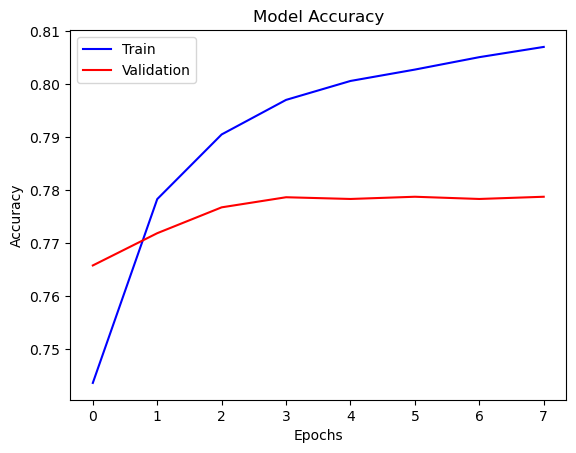

In [9]:
plt.plot(history.history['accuracy'], 'b')
plt.plot(history.history['val_accuracy'], 'r')
plt.title('Model Accuracy'),
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [10]:
y_test = tf.keras.utils.to_categorical(y_test, num_classes= 3)
print(y_test.shape, X_test.shape)

(23924, 3) (23924, 52)


In [11]:
scores = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', scores[1])

Test accuracy: 0.7733238339424133


In [12]:
a = model.predict(X_test)

748/748 [==============================] - 2s 2ms/step


In [13]:
all_models.append(model)

# **Model 1**

In [14]:
from keras.layers import LSTM
model1 = keras.models.Sequential()
model1.add(keras.layers.Embedding(18079+1, 52, input_length=52)) 
model1.add(LSTM(100))
model1.add(keras.layers.Dense(10, activation="relu"))
model1.add(keras.layers.Dense(3, activation="softmax")) 

In [15]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 52, 52)            940160    
                                                                 
 lstm (LSTM)                 (None, 100)               61200     
                                                                 
 dense_5 (Dense)             (None, 10)                1010      
                                                                 
 dense_6 (Dense)             (None, 3)                 33        
                                                                 
Total params: 1,002,403
Trainable params: 1,002,403
Non-trainable params: 0
_________________________________________________________________


In [16]:
model1.compile(loss= "categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [17]:
history = model1.fit(X_train, y_train, epochs = epoch, verbose=2, validation_data=(X_val,y_val), callbacks = [callback]) # the validation data should be provied as tuple or less there is a huge error in format matching

Epoch 1/8
6056/6056 - 78s - loss: 0.5796 - accuracy: 0.7592 - val_loss: 0.4962 - val_accuracy: 0.7931 - 78s/epoch - 13ms/step
Epoch 2/8
6056/6056 - 46s - loss: 0.4507 - accuracy: 0.8093 - val_loss: 0.4718 - val_accuracy: 0.8022 - 46s/epoch - 8ms/step
Epoch 3/8
6056/6056 - 45s - loss: 0.4021 - accuracy: 0.8282 - val_loss: 0.4694 - val_accuracy: 0.8067 - 45s/epoch - 7ms/step
Epoch 4/8
6056/6056 - 45s - loss: 0.3695 - accuracy: 0.8420 - val_loss: 0.4841 - val_accuracy: 0.8061 - 45s/epoch - 7ms/step
Epoch 5/8
6056/6056 - 45s - loss: 0.3443 - accuracy: 0.8517 - val_loss: 0.4947 - val_accuracy: 0.8070 - 45s/epoch - 7ms/step
Epoch 6/8
6056/6056 - 44s - loss: 0.3228 - accuracy: 0.8593 - val_loss: 0.5041 - val_accuracy: 0.8017 - 44s/epoch - 7ms/step
Epoch 7/8
6056/6056 - 45s - loss: 0.3035 - accuracy: 0.8667 - val_loss: 0.5277 - val_accuracy: 0.7993 - 45s/epoch - 7ms/step
Epoch 8/8
Restoring model weights from the end of the best epoch: 5.
6056/6056 - 44s - loss: 0.2858 - accuracy: 0.8741 - val

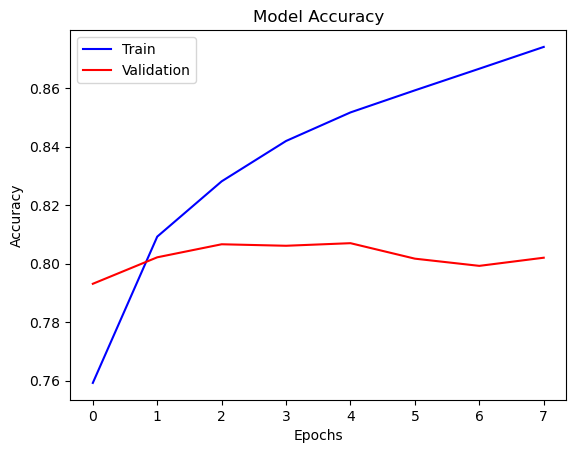

In [18]:
plt.plot(history.history['accuracy'], 'b')
plt.plot(history.history['val_accuracy'], 'r')
plt.title('Model Accuracy'),
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [19]:
scores = model1.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', scores[1])

Test accuracy: 0.8061360716819763


In [20]:
all_models.append(model1)

# **Model 2**

In [21]:
from keras.layers import LSTM
from keras.layers import Bidirectional, Dense
model2 = keras.models.Sequential()
model2.add(keras.layers.Embedding(18079+1, 52, input_length=52))
model2.add(Bidirectional(LSTM(52)))
model2.add(keras.layers.Dense(10, activation="relu"))
model2.add(keras.layers.Dense(3, activation="softmax"))

In [22]:
model2.compile(loss= "categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [23]:
model2.fit(X_train, y_train, epochs = epoch, verbose=2, validation_data=(X_val,y_val), callbacks = [callback])

Epoch 1/8
6056/6056 - 82s - loss: 0.5779 - accuracy: 0.7579 - val_loss: 0.4992 - val_accuracy: 0.7909 - 82s/epoch - 13ms/step
Epoch 2/8
6056/6056 - 58s - loss: 0.4493 - accuracy: 0.8108 - val_loss: 0.4721 - val_accuracy: 0.8021 - 58s/epoch - 10ms/step
Epoch 3/8
6056/6056 - 57s - loss: 0.3999 - accuracy: 0.8304 - val_loss: 0.4727 - val_accuracy: 0.8054 - 57s/epoch - 9ms/step
Epoch 4/8
6056/6056 - 60s - loss: 0.3671 - accuracy: 0.8431 - val_loss: 0.4774 - val_accuracy: 0.8073 - 60s/epoch - 10ms/step
Epoch 5/8
6056/6056 - 60s - loss: 0.3415 - accuracy: 0.8532 - val_loss: 0.4944 - val_accuracy: 0.8069 - 60s/epoch - 10ms/step
Epoch 6/8
6056/6056 - 60s - loss: 0.3196 - accuracy: 0.8609 - val_loss: 0.5089 - val_accuracy: 0.8037 - 60s/epoch - 10ms/step
Epoch 7/8
Restoring model weights from the end of the best epoch: 4.
6056/6056 - 61s - loss: 0.3002 - accuracy: 0.8688 - val_loss: 0.5241 - val_accuracy: 0.8010 - 61s/epoch - 10ms/step
Epoch 7: early stopping


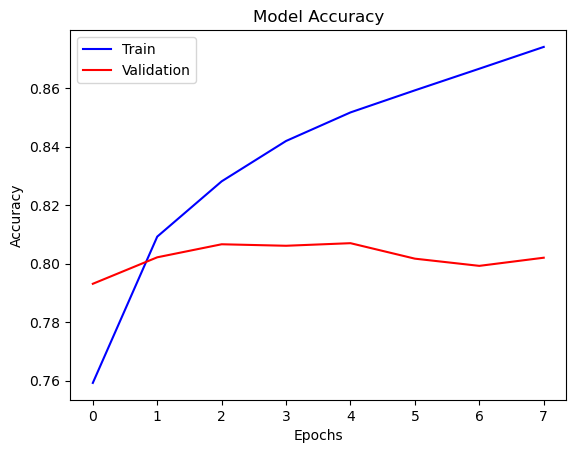

In [24]:
plt.plot(history.history['accuracy'], 'b')
plt.plot(history.history['val_accuracy'], 'r')
plt.title('Model Accuracy'),
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [25]:
scores = model2.evaluate(X_test, y_test, verbose=2)
print('Test accuracy:', scores[1])

748/748 - 3s - loss: 0.4834 - accuracy: 0.8057 - 3s/epoch - 4ms/step
Test accuracy: 0.8057181239128113


In [26]:
all_models.append(model2)

# **Ensembled Model**

In [27]:
def final_pred(X):
    preds = []
    for model in all_models[:]:
        pred = model.predict(X)
        pred = np.argmax(pred,axis=1)
        preds.append(pred)
    final = np.vstack((preds[0],preds[1],preds[2]))
#     final = np.vstack((preds[0],preds[1]))
    final = np.array(final)
    final = np.transpose(final)
    f = []
    for i in final:
        a,b = np.unique(i,axis=0,return_counts=True)
        f.append(a[np.argmax(b)])
    return f

In [28]:
k = final_pred(X_test)

748/748 [==============================] - 4s 4ms/step


In [29]:
accuracy_score(np.argmax(model.predict(X_test),axis=1),org_y_test)

748/748 [==============================] - 2s 3ms/step


0.7733238588864738

In [30]:
accuracy_score(np.argmax(model1.predict(X_test),axis=1),org_y_test)

748/748 [==============================] - 2s 3ms/step


0.8061360976425347

In [31]:
accuracy_score(np.argmax(model2.predict(X_test),axis=1),org_y_test)

748/748 [==============================] - 3s 4ms/step


0.8057181073399097

**Ensembled model accuracy**

In [32]:
accuracy_score(k,org_y_test)  

0.8080588530346096